# Skin Cancer Image Classification Based on ResNet

This is Final Project of CVDL Course in xAIM. This study uses ResNet model to classify skin cancer images in HAM10000 dataset.

Zhonghua Qi


In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zhonghuaqi","key":"c16a2b7905b15e43803de1e50a46d5d2"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: ham10000_images_part_2/IS

In [4]:
# import libreries

import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import torch
torch.manual_seed(111)

from torch import nn
import torch.optim as optim
import torchvision

from torchvision import transforms, models, datasets

import time
import shutil
import random
import sys
import copy
import shutil

In [5]:
def create_class_folders(directory):

    ### Create folders for each class within the specified directory. ###

    classes = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

    for class_name in classes:
        class_dir = os.path.join(directory, class_name)
        os.mkdir(class_dir)

# Create a new directory
data_dir = 'data_dir'
os.mkdir(data_dir)

# Create train and validation directories
train_dir = os.path.join(data_dir, 'train')
os.mkdir(train_dir)

valid_dir = os.path.join(data_dir, 'valid')
os.mkdir(valid_dir)

# Create class folders inside train and validation directories
create_class_folders(train_dir)
create_class_folders(valid_dir)

In [6]:
df_data = pd.read_csv('/content/HAM10000_metadata.csv')

#df_data.head()

In [8]:
from sklearn.model_selection import train_test_split


# def filter_single_images(df):
#     # Filter out lesion_id's that have only one image associated with them.

#     grouped_df = df.groupby('lesion_id').count()
#     single_image_ids = grouped_df[grouped_df['image_id'] == 1].index
#     return df[df['lesion_id'].isin(single_image_ids)].reset_index(drop=True)

# def identify_duplicates(x, unique_list):
#     # Identify if a lesion_id has duplicate images.

#     if x in unique_list:
#         return 'no_duplicates'
#     else:
#         return 'has_duplicates'

def split_train_val(df, val_size=0.17, random_state=101):
    #  Split the data into training and validation sets.
    y = df['dx']
    _, df_val = train_test_split(df, test_size=val_size, random_state=random_state, stratify=y)
    return df_val


# # Filter out lesion_id's with only one image
# df_data_filtered = filter_single_images(df_data)

# # Identify duplicates
# unique_lesion_ids = set(df_data_filtered['lesion_id'])
# df_data_filtered['duplicates'] = df_data_filtered['lesion_id'].apply(lambda x: identify_duplicates(x, unique_lesion_ids))

# # Split data into training and validation sets
df_val = split_train_val(df_data)

df_train = df_data[~df_data['image_id'].isin(df_val['image_id'])]


# # Identify train and val rows
# df_data_filtered['train_or_val'] = identify_train_val(df_data_filtered, df_val)

# # Filter out train rows
# df_train = df_data[df_data_filtered['train_or_val'] == 'train']

# print("Number of samples in training set:", len(df_train))
# print("Number of samples in validation set:", len(df_val))

In [9]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

# Define a function to transfer images from source to destination
def transfer_images(image_list, source_folders, destination_dir):
    for image_id in image_list:
        file_name = f"{image_id}.jpg"
        label = df_data.loc[image_id, 'dx']
        for folder in source_folders:
            source_path = os.path.join(folder, file_name)
            if os.path.isfile(source_path):
                destination_path = os.path.join(destination_dir, label, file_name)
                shutil.copyfile(source_path, destination_path)
                break

# Paths to the image folders
folder_1 = '/content/HAM10000_images_part_1'
folder_2 = '/content/HAM10000_images_part_2'
source_folders = [folder_1, folder_2]

# Get a list of train and val images
train_list = df_train['image_id'].tolist()
val_list = df_val['image_id'].tolist()

# Transfer the train and val images
transfer_images(train_list, source_folders, train_dir)
transfer_images(val_list, source_folders, valid_dir)

In [10]:
print(len(os.listdir('data_dir/train/nv')))
print(len(os.listdir('data_dir/train/mel')))
print(len(os.listdir('data_dir/train/bkl')))
print(len(os.listdir('data_dir/train/bcc')))
print(len(os.listdir('data_dir/train/akiec')))
print(len(os.listdir('data_dir/train/vasc')))
print(len(os.listdir('data_dir/train/df')))

5565
924
912
427
271
118
95


In [11]:
print(len(os.listdir('data_dir/valid/nv')))
print(len(os.listdir('data_dir/valid/mel')))
print(len(os.listdir('data_dir/valid/bkl')))
print(len(os.listdir('data_dir/valid/bcc')))
print(len(os.listdir('data_dir/valid/akiec')))
print(len(os.listdir('data_dir/valid/vasc')))
print(len(os.listdir('data_dir/valid/df')))

1140
189
187
87
56
24
20


In [12]:
# Data Augmentation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([256,256]),
        transforms.RandomRotation(45),# Randomly rotate -45~45 degrees
        transforms.CenterCrop(224),#224*224 Final images
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        # transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), #Change color
        # transforms.RandomGrayscale(p=0.025),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#Mean and standard deviation of Imagenet dataset
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [13]:
batch_size = 32

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [14]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 8312
     Root location: data_dir/train
     StandardTransform
 Transform: Compose(
                Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=True)
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'valid': Dataset ImageFolder
     Number of datapoints: 1703
     Root location: data_dir/valid
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [15]:
model_name = 'resnet'

## Select from ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']

feature_extract = True

In [16]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [17]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [18]:
model_ft = models.resnet50() #18 34 50 101 152-layers
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):

    #Refer to the pytorch official website example

    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 7), #The number of skin cancer categories is 7
                                   nn.LogSoftmax(dim=1))
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [21]:
model_ft, input_size = initialize_model(model_name, 7, feature_extract, use_pretrained=True)

# Computed by GPU
model_ft = model_ft.to(device)

# Model saving
filename = 'best_checkpoint.pth'

# Train all layers???
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


Params to learn:
	 fc.0.weight
	 fc.0.bias


In [22]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
# Optimizer&Scheduler Settings
optimizer_ft = optim.Adam(params_to_update, lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
criterion = nn.NLLLoss()

In [24]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=50, is_inception=False,filename=filename):

    since = time.time()
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []

    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Train&Valid
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero
                optimizer.zero_grad()
                # Calculate and update grad only during training
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate loss
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))


            # Getting the best model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(), # Layer name: weights
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                #scheduler.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        scheduler.step()
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
        scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # After training, the best one as the final result of the model.
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs

In [25]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, scheduler = scheduler, num_epochs=50, is_inception=(model_name=="inception"))


Epoch 0/49
----------
Time elapsed 2m 9s
train Loss: 0.8688 Acc: 0.7014
Time elapsed 2m 34s
valid Loss: 0.7290 Acc: 0.7358
Optimizer learning rate : 0.0010000

Epoch 1/49
----------
Time elapsed 4m 36s
train Loss: 0.7249 Acc: 0.7398
Time elapsed 5m 0s
valid Loss: 0.6731 Acc: 0.7587
Optimizer learning rate : 0.0010000

Epoch 2/49
----------
Time elapsed 6m 58s
train Loss: 0.6870 Acc: 0.7489
Time elapsed 7m 23s
valid Loss: 0.7449 Acc: 0.7540
Optimizer learning rate : 0.0010000

Epoch 3/49
----------
Time elapsed 9m 21s
train Loss: 0.6690 Acc: 0.7578
Time elapsed 9m 45s
valid Loss: 0.6447 Acc: 0.7763
Optimizer learning rate : 0.0010000

Epoch 4/49
----------
Time elapsed 11m 42s
train Loss: 0.6651 Acc: 0.7534
Time elapsed 12m 6s
valid Loss: 0.6678 Acc: 0.7528
Optimizer learning rate : 0.0010000

Epoch 5/49
----------
Time elapsed 14m 3s
train Loss: 0.6096 Acc: 0.7763
Time elapsed 14m 28s
valid Loss: 0.6338 Acc: 0.7821
Optimizer learning rate : 0.0001000

Epoch 6/49
----------
Time elapsed

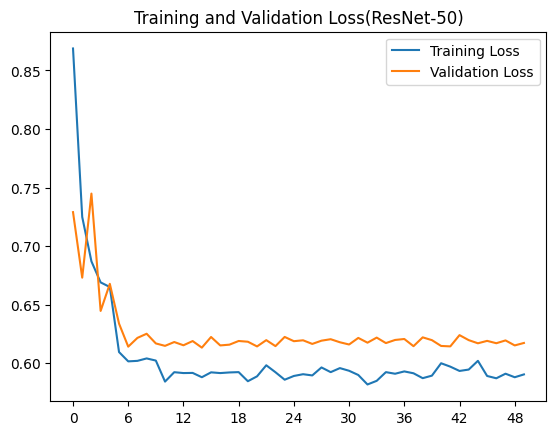

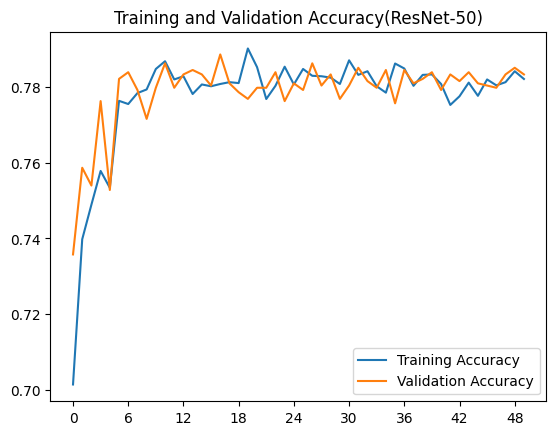

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Plot training history
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss(ResNet-50)')
#plt.xticks(x)
plt.show()
# Plot the training loss values recorded during each epoch and the validation loss values recorded during each epoch.
# OK Decreasing
# KO Large gap = overfitting

train_acc_history_list = [tensor.item() for tensor in train_acc_history]
val_acc_history_list = [tensor.item() for tensor in val_acc_history]

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(train_acc_history_list, label='Training Accuracy')
plt.plot(val_acc_history_list, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy(ResNet-50)')
#plt.xticks(x)
plt.show()
# Plot the accuracy of training and validation during each epoch.
# OK Increasing
# KO Large gap = overfitting